# How Accurate is Polling in Predicting US Presidential Election Winners, Especially in the Age of Social Media?

## What Historical Averages and Baseline Models Reveal

### Welcome to my TedxTalk

My dataset is built on the **average national polling percentages** for both Democratic and Republican candidates in each U.S. presidential election year. Instead of looking only at the last poll before Election Day, I wanted to capture the bigger picture: **how well did the entire polling trend across the year actually predict the real winner?** This approach helps me test whether the general climate of the polls—the information that analysts, media, and campaigns were actually seeing—lined up with the final outcome.

#### How I Built the Dataset

- I started by scraping data from [Wikipedia’s US Presidential Election polling page](https://en.wikipedia.org/wiki/Polling_for_United_States_presidential_elections).  
    - For earlier years (1936 to early 2000s), most data came from **Gallup Trial‑Heat Polls**.
    - In more recent decades, the data is a **mix of Gallup and other major pollsters**.
    - These sources gave me monthly polling averages for each year.

- I wrote code to convert this scraped data into **individual dataframes for each year**.  
    - All these dataframes were then combined into a single historical polling dataset called **Historical_Polling_Data_Set**.

- I repeated the process for **actual election results**, scraping the historical data from [270towin.com](https://www.270towin.com).  
    - I cleaned and merged all results by year into one master dataframe.

- Next, I combined the historical polling and actual election results into a new file: **Historic_Baseline_Model_Poll_vs_Actual_Combined.csv**.

- For a solid baseline model, I knew I would need a very clean and focused structure, so I started this notebook with more data cleaning:
    - I **averaged the polling numbers for each party by year**.
    - I determined **which party led the polls each year**.
    - I created columns showing **which party won the election** by both **electoral college** (which determines the presidency) and **popular vote** (useful for future analysis, especially for understanding frustrations around the electoral college system).
    - I made a copy that kept only the main columns needed for baseline modeling: the poll leader, the poll margin, and the election winner.

- From here, I was ready to test the predictive power of polling using different models:
    - **Logistic Regression**
    - Random Forest (May not work on such a small dataset but wanted to test it out anyway)
    - XGBoost (same as Random Forest)

Below you’ll find the results of each model tested on the historical polling data and my final analysis on whether polling actually has predictive power for US presidential election outcomes, especially through the lens of the electoral college.

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt

# Read in your dataset
df = pd.read_csv('Historic_Baseline_Model_Poll_vs_Actual_Combined.csv')

# Quick check of the first few rows
#df.head(60)

In [2]:
# Groups by year and calculates the average of all column per year
df = df.groupby('year').mean(numeric_only=True).reset_index().round(2)

# Sets Poll Leader Column to show 0 if Dem won that year, 1 if Rep won that year 
# Based of the Demoratic and Republican Columns 
df['Poll_Leader'] = (df['Republican'] > df['Democratic']).astype(int)

# Sets election_winner to show 0 if dem won that year, 1 if Rep won that year
# Based of the Republican_Electoral and Democrat_Electoral Columns 
# (Indicative of Electoral College Win which is how canidates win the US Presidency)
df['election_winner'] = (df['Republican_Electoral'] > df['Democrat_Electoral']).astype(int)

# Renames election_winner to EC_election_winner
df = df.rename(columns={'election_winner': 'EC_election_winner'})

# Creates a new column PC_election_winner
# Sets PC_electioin_winner to show 0 if dem won that year, 1 if rep won that year
# Based on Republican_Popular and Democrat_Popular Columns
# (Indicative of Polular Vote win which would be interesting to dive into in later iterations of this project)
df['PC_election_winner'] = (df['Republican_Popular'] > df['Democrat_Popular']).astype(int)

# Drop Duplicates
df = df.loc[:,~df.columns.duplicated()]

df.columns

Index(['year', 'Democratic', 'Republican', 'Poll_Leading_Margin',
       'Poll_Leader', 'EC_election_winner', 'Republican_Electoral',
       'Democrat_Electoral', 'Republican_Popular', 'Democrat_Popular',
       'Total_Popular_Vote (Total votes cast in Presidential Election)',
       'Republican_Electoral_pct (out of 270)',
       'Democrat_Electoral_pct (out of 270)',
       'Republican_Popular_pct (Out of total votes cast in Presidential Election)',
       'Democrat_Popular_pct (Out of total votes cast in Presidential Election)',
       'Electoral_Leading_Margin (difference between dem and rep electorial pct)',
       'Popular_Leading_Margin (difference between dem and rep popular vote pct)',
       'Poll_vs_Electoral_Margin_Diff', 'Poll_vs_Popular_Margin_Diff',
       'PC_election_winner'],
      dtype='object')

In [3]:
df

,year,Democratic,Republican,Poll_Leading_Margin,Poll_Leader,EC_election_winner,Republican_Electoral,Democrat_Electoral,Republican_Popular,Democrat_Popular,Total_Popular_Vote (Total votes cast in Presidential Election),Republican_Electoral_pct (out of 270),Democrat_Electoral_pct (out of 270),Republican_Popular_pct (Out of total votes cast in Presidential Election),Democrat_Popular_pct (Out of total votes cast in Presidential Election),Electoral_Leading_Margin (difference between dem and rep electorial pct),Popular_Leading_Margin (difference between dem and rep popular vote pct),Poll_vs_Electoral_Margin_Diff,Poll_vs_Popular_Margin_Diff,PC_election_winner
0,1936,50.33,44.44,5.89,0,0,8.0,523.0,16679583.0,27751597.0,44431180.0,2.96,193.70,37.54,62.46,190.74,24.92,-184.85,-19.03,0
1,1940,48.12,42.75,5.38,0,0,82.0,449.0,22305198.0,27244160.0,49549358.0,30.37,166.30,45.02,54.98,135.93,9.96,-130.56,-4.58,0
2,1944,49.22,44.33,4.89,0,0,99.0,432.0,22006285.0,25602504.0,47608789.0,36.67,160.00,46.22,53.78,123.33,7.56,-118.44,-2.67,0
3,1948,39.60,47.20,8.60,1,0,189.0,303.0,21969170.0,24105695.0,46074865.0,70.00,112.22,47.68,52.32,42.22,4.64,-33.62,3.96,0
4,1952,40.11,52.22,12.11,1,1,442.0,89.0,33778963.0,27314992.0,61093955.0,163.70,32.96,55.29,44.71,130.74,10.58,-118.63,1.53,1
5,1956,37.33,58.17,20.83,1,1,457.0,73.0,35581003.0,25738765.0,61319768.0,169.26,27.04,58.03,41.97,142.22,16.06,-121.39,4.77,1
6,1960,47.93,47.00,2.93,0,0,219.0,303.0,34107646.0,34227096.0,68334742.0,81.11,112.22,49.91,50.09,31.11,0.18,-28.18,2.75,0
7,1964,66.00,27.78,38.22,0,0,52.0,486.0,27146969.0,42825463.0,69972432.0,19.26,180.00,38.80,61.20,160.74,22.40,-122.52,15.82,0
8,1968,35.58,41.00,8.08,1,1,301.0,191.0,31710470.0,30898055.0,62608525.0,111.48,70.74,50.65,49.35,40.74,1.30,-32.66,6.78,1
9,1972,34.44,58.33,23.89,1,1,520.0,17.0,46740323.0,28901598.0,75641921.0,192.59,6.30,61.79,38.21,186.29,23.58,-162.40,0.31,1


In [4]:
# Creates EC_Poll_Accurate column which states if Poll_Leader matched EC_election_winner
df['EC_Poll_Accurate'] = (df['Poll_Leader'] == df['EC_election_winner']).astype(int)

# Creates PC_Poll_Accurate column which states if Poll_Leader matched PC_election_winner
df['PC_Poll_Accurate'] = (df['Poll_Leader'] == df['PC_election_winner']).astype(int)

df

,year,Democratic,Republican,Poll_Leading_Margin,Poll_Leader,EC_election_winner,Republican_Electoral,Democrat_Electoral,Republican_Popular,Democrat_Popular,...,Democrat_Electoral_pct (out of 270),Republican_Popular_pct (Out of total votes cast in Presidential Election),Democrat_Popular_pct (Out of total votes cast in Presidential Election),Electoral_Leading_Margin (difference between dem and rep electorial pct),Popular_Leading_Margin (difference between dem and rep popular vote pct),Poll_vs_Electoral_Margin_Diff,Poll_vs_Popular_Margin_Diff,PC_election_winner,EC_Poll_Accurate,PC_Poll_Accurate
0,1936,50.33,44.44,5.89,0,0,8.0,523.0,16679583.0,27751597.0,...,193.70,37.54,62.46,190.74,24.92,-184.85,-19.03,0,1,1
1,1940,48.12,42.75,5.38,0,0,82.0,449.0,22305198.0,27244160.0,...,166.30,45.02,54.98,135.93,9.96,-130.56,-4.58,0,1,1
2,1944,49.22,44.33,4.89,0,0,99.0,432.0,22006285.0,25602504.0,...,160.00,46.22,53.78,123.33,7.56,-118.44,-2.67,0,1,1
3,1948,39.60,47.20,8.60,1,0,189.0,303.0,21969170.0,24105695.0,...,112.22,47.68,52.32,42.22,4.64,-33.62,3.96,0,0,0
4,1952,40.11,52.22,12.11,1,1,442.0,89.0,33778963.0,27314992.0,...,32.96,55.29,44.71,130.74,10.58,-118.63,1.53,1,1,1
5,1956,37.33,58.17,20.83,1,1,457.0,73.0,35581003.0,25738765.0,...,27.04,58.03,41.97,142.22,16.06,-121.39,4.77,1,1,1
6,1960,47.93,47.00,2.93,0,0,219.0,303.0,34107646.0,34227096.0,...,112.22,49.91,50.09,31.11,0.18,-28.18,2.75,0,1,1
7,1964,66.00,27.78,38.22,0,0,52.0,486.0,27146969.0,42825463.0,...,180.00,38.80,61.20,160.74,22.40,-122.52,15.82,0,1,1
8,1968,35.58,41.00,8.08,1,1,301.0,191.0,31710470.0,30898055.0,...,70.74,50.65,49.35,40.74,1.30,-32.66,6.78,1,1,1
9,1972,34.44,58.33,23.89,1,1,520.0,17.0,46740323.0,28901598.0,...,6.30,61.79,38.21,186.29,23.58,-162.40,0.31,1,1,1


In [5]:
df.columns

Index(['year', 'Democratic', 'Republican', 'Poll_Leading_Margin',
       'Poll_Leader', 'EC_election_winner', 'Republican_Electoral',
       'Democrat_Electoral', 'Republican_Popular', 'Democrat_Popular',
       'Total_Popular_Vote (Total votes cast in Presidential Election)',
       'Republican_Electoral_pct (out of 270)',
       'Democrat_Electoral_pct (out of 270)',
       'Republican_Popular_pct (Out of total votes cast in Presidential Election)',
       'Democrat_Popular_pct (Out of total votes cast in Presidential Election)',
       'Electoral_Leading_Margin (difference between dem and rep electorial pct)',
       'Popular_Leading_Margin (difference between dem and rep popular vote pct)',
       'Poll_vs_Electoral_Margin_Diff', 'Poll_vs_Popular_Margin_Diff',
       'PC_election_winner', 'EC_Poll_Accurate', 'PC_Poll_Accurate'],
      dtype='object')

In [6]:
# Re Order Data Frame for clarity

Order = [
    'year', 'Poll_Leading_Margin', 'Poll_Leader', 'EC_election_winner',
    'PC_election_winner', 'EC_Poll_Accurate', 'PC_Poll_Accurate', 'Democratic', 'Republican',
    'Republican_Electoral',
    'Democrat_Electoral', 'Republican_Popular', 'Democrat_Popular',
    'Total_Popular_Vote (Total votes cast in Presidential Election)',
    'Republican_Electoral_pct (out of 270)',
    'Democrat_Electoral_pct (out of 270)',
    'Republican_Popular_pct (Out of total votes cast in Presidential Election)',
    'Democrat_Popular_pct (Out of total votes cast in Presidential Election)',
    'Electoral_Leading_Margin (difference between dem and rep electorial pct)',
    'Popular_Leading_Margin (difference between dem and rep popular vote pct)',
    'Poll_vs_Electoral_Margin_Diff', 'Poll_vs_Popular_Margin_Diff'
]

df = df[Order]


df

,year,Poll_Leading_Margin,Poll_Leader,EC_election_winner,PC_election_winner,EC_Poll_Accurate,PC_Poll_Accurate,Democratic,Republican,Republican_Electoral,...,Democrat_Popular,Total_Popular_Vote (Total votes cast in Presidential Election),Republican_Electoral_pct (out of 270),Democrat_Electoral_pct (out of 270),Republican_Popular_pct (Out of total votes cast in Presidential Election),Democrat_Popular_pct (Out of total votes cast in Presidential Election),Electoral_Leading_Margin (difference between dem and rep electorial pct),Popular_Leading_Margin (difference between dem and rep popular vote pct),Poll_vs_Electoral_Margin_Diff,Poll_vs_Popular_Margin_Diff
0,1936,5.89,0,0,0,1,1,50.33,44.44,8.0,...,27751597.0,44431180.0,2.96,193.70,37.54,62.46,190.74,24.92,-184.85,-19.03
1,1940,5.38,0,0,0,1,1,48.12,42.75,82.0,...,27244160.0,49549358.0,30.37,166.30,45.02,54.98,135.93,9.96,-130.56,-4.58
2,1944,4.89,0,0,0,1,1,49.22,44.33,99.0,...,25602504.0,47608789.0,36.67,160.00,46.22,53.78,123.33,7.56,-118.44,-2.67
3,1948,8.60,1,0,0,0,0,39.60,47.20,189.0,...,24105695.0,46074865.0,70.00,112.22,47.68,52.32,42.22,4.64,-33.62,3.96
4,1952,12.11,1,1,1,1,1,40.11,52.22,442.0,...,27314992.0,61093955.0,163.70,32.96,55.29,44.71,130.74,10.58,-118.63,1.53
5,1956,20.83,1,1,1,1,1,37.33,58.17,457.0,...,25738765.0,61319768.0,169.26,27.04,58.03,41.97,142.22,16.06,-121.39,4.77
6,1960,2.93,0,0,0,1,1,47.93,47.00,219.0,...,34227096.0,68334742.0,81.11,112.22,49.91,50.09,31.11,0.18,-28.18,2.75
7,1964,38.22,0,0,0,1,1,66.00,27.78,52.0,...,42825463.0,69972432.0,19.26,180.00,38.80,61.20,160.74,22.40,-122.52,15.82
8,1968,8.08,1,1,1,1,1,35.58,41.00,301.0,...,30898055.0,62608525.0,111.48,70.74,50.65,49.35,40.74,1.30,-32.66,6.78
9,1972,23.89,1,1,1,1,1,34.44,58.33,520.0,...,28901598.0,75641921.0,192.59,6.30,61.79,38.21,186.29,23.58,-162.40,0.31


In [7]:
df.to_csv('Baseline_Model_Data.csv', index=False)

In [8]:
# Main columns needed are year	
#Poll_Leading_Margin	
#Poll_Leader	
#EC_election_winner	
#PC_election_winner	
#EC_Poll_Accurate	
#PC_Poll_Accurate

#Read File back in:
df_baseline = pd.read_csv('Baseline_Model_Data.csv')

# Kept the others for future iterations of the project

# Copy to keep only the main columns
df_baseline = df[['year', 'Poll_Leading_Margin', 'Poll_Leader', 'EC_election_winner', 'PC_election_winner', 'EC_Poll_Accurate', 'PC_Poll_Accurate']].copy()


df_baseline

,year,Poll_Leading_Margin,Poll_Leader,EC_election_winner,PC_election_winner,EC_Poll_Accurate,PC_Poll_Accurate
0,1936,5.89,0,0,0,1,1
1,1940,5.38,0,0,0,1,1
2,1944,4.89,0,0,0,1,1
3,1948,8.60,1,0,0,0,0
4,1952,12.11,1,1,1,1,1
5,1956,20.83,1,1,1,1,1
6,1960,2.93,0,0,0,1,1
7,1964,38.22,0,0,0,1,1
8,1968,8.08,1,1,1,1,1
9,1972,23.89,1,1,1,1,1


In [9]:
df_baseline.to_csv('Baseline_Model_Data1.csv', index=False)

----

# Visualizing Polling Accuracy Over the Years

In [10]:
# Created a copy of the data frame to show:
# Year, Poll Leader, and EC Election Winner 
# The both columns 0s and 1s were relabeled with Democrat and Republican

df_visualize = df[['year', 'Poll_Leader', 'EC_election_winner']].copy()

df_visualize['Poll_Leader'] = df_visualize['Poll_Leader'].map({0: 'Democrat', 1: 'Republican'})
df_visualize['EC_election_winner'] = df_visualize['EC_election_winner'].map({0: 'Democrat', 1: 'Republican'})


df_visualize

,year,Poll_Leader,EC_election_winner
0,1936,Democrat,Democrat
1,1940,Democrat,Democrat
2,1944,Democrat,Democrat
3,1948,Republican,Democrat
4,1952,Republican,Republican
5,1956,Republican,Republican
6,1960,Democrat,Democrat
7,1964,Democrat,Democrat
8,1968,Republican,Republican
9,1972,Republican,Republican


#### The Average Polling Accuracy Historically from 1936-2024

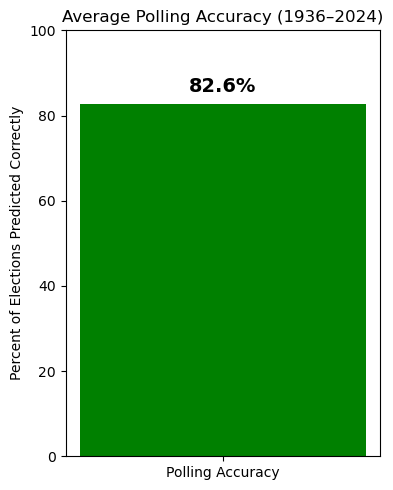

In [11]:
# Calculate overall accuracy as a percentage
overall_accuracy = df['EC_Poll_Accurate'].mean() * 100

# Plot a single bar for average accuracy
plt.figure(figsize=(4, 5))
plt.bar(['Polling Accuracy'], [overall_accuracy], color='green')
plt.ylim(0, 100)
plt.ylabel('Percent of Elections Predicted Correctly')
plt.title('Average Polling Accuracy (1936–2024)')

# Annotate bar with value
plt.text(0, overall_accuracy + 2, f"{overall_accuracy:.1f}%", 
         ha='center', va='bottom', fontsize=14, color='black', fontweight='bold')

plt.tight_layout()
plt.show()

#### Years Accurately Predicting Winner Based of Polling Leader

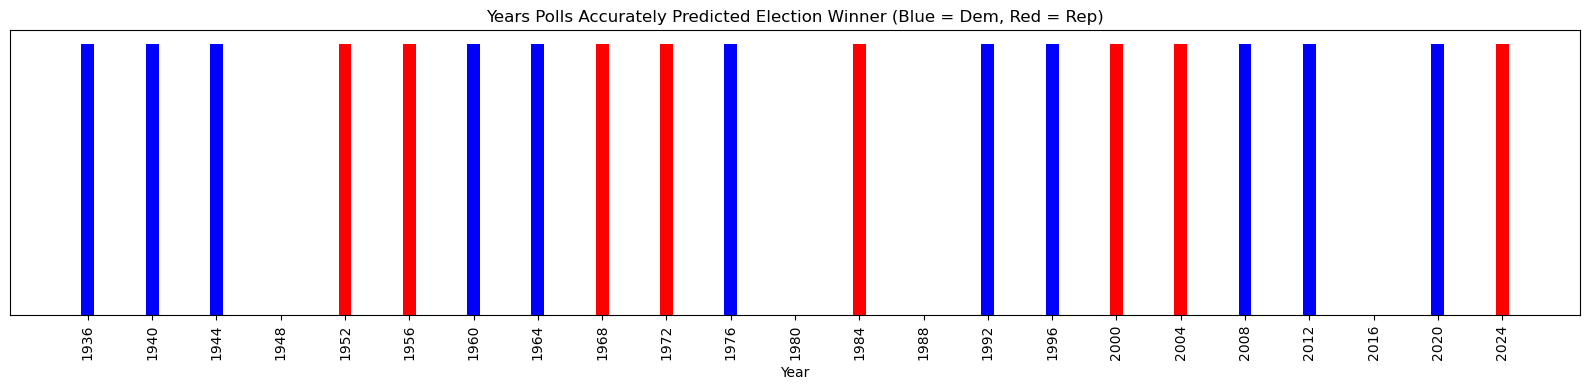

In [12]:
plt.figure(figsize=(16, 4))

# Mask for correct predictions
accurate_years = df['Poll_Leader'] == df['EC_election_winner']
correct = df[accurate_years]

# Map winner to color where its blue for Dem and red for Rep
colors = correct['EC_election_winner'].map({0: 'blue', 1: 'red'}).tolist()

# Plot all bars at once, each with its assigned color
plt.bar(correct['year'], [1]*len(correct), color=colors)

plt.xticks(df['year'], rotation=90)
plt.yticks([])  # Hide y axis
plt.xlabel('Year')
plt.title('Years Polls Accurately Predicted Election Winner (Blue = Dem, Red = Rep)')
plt.tight_layout()
plt.show()

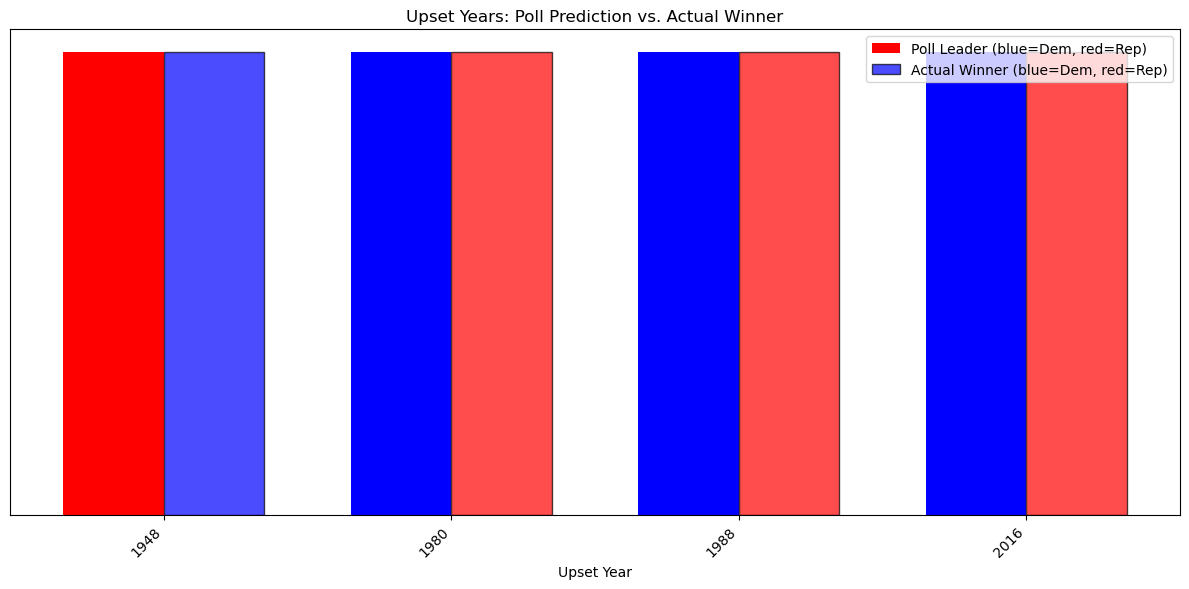

In [13]:
# Bar chart to see what the upset years predicted versus who won 

import numpy as np

upset_years = [1948, 1980, 1988, 2016]

upsets = df_visualize[df_visualize['year'].isin(upset_years)].copy()

x = np.arange(len(upsets))
width = 0.35

# Color mapping
poll_colors = upsets['Poll_Leader'].map({'Democrat': 'blue', 'Republican': 'red'})
winner_colors = upsets['EC_election_winner'].map({'Democrat': 'blue', 'Republican': 'red'})

plt.figure(figsize=(12, 6))

# Poll Leader bar (left)
plt.bar(x - width/2, [1]*len(x), width=width, color=poll_colors, label='Poll Leader (blue=Dem, red=Rep)')

# Actual Winner bar (right)
plt.bar(x + width/2, [1]*len(x), width=width, color=winner_colors, label='Actual Winner (blue=Dem, red=Rep)', alpha=0.7, edgecolor='black')

plt.xticks(x, upsets['year'], rotation=45, ha='right')
plt.yticks([])  
plt.xlabel('Upset Year')
plt.title('Upset Years: Poll Prediction vs. Actual Winner')
plt.legend()
plt.tight_layout()
plt.show()

#### What Do the Visuals Say About Polling and Election Prediction?

- The **first green bar chart** shows that, across all U.S. presidential elections since 1936, polls have correctly predicted the winner about 83% of the time. This sets a strong baseline but also means that around one in six elections was an upset where the polls got it wrong.
  
- The **second chart** breaks this down year by year:
    - Each **blue bar** represents a year when polls correctly predicted a Democratic win.
    - Each **red bar** represents a year when polls correctly called a Republican win.
    - **Missing bars** show the years when there was an upset—the poll leader lost the election. These gaps help us see patterns in when and how often polls missed the mark.

.
- The **third chart** zooms in on just the upset years:
    - For each upset year, there are **two bars**: one for the poll leader and one for the actual winner.
    - The color of each bar shows which party was expected to win (according to polls) and which party actually won.
    - This makes it easy to spot the direction of polling errors and see if any trends stand out.

.
- **Important points**:
    - Polling has usually been pretty reliable, but there have always been exceptions that matter, especially in close or high-stakes elections.
    - Early polling (before the 1960s) might have been more accurate partly because the electorate was smaller and less diverse, and polling was still developing as a science.
    - Major societal changes—like the civil rights movement, women's suffrage, and advances in technology—forced polling to adapt, and may have made it harder to get truly representative results as time went on.


**So, why do I need to build a baseline model when I already have the historical average?**

The baseline model helps me **simulate how well I could actually predict a future election** using only the polling data available before Election Day. This is the real test for whether polling can still be trusted for forecasting, not just for explaining what happened after the fact.

The baseline model also gives me a **fair way to compare polling to newer tools**, like sentiment analysis from social media. If polling data alone is not enough, or if its limits are built in, it makes sense to see if something like sentiment analysis could do a better job at capturing late shifts or hidden trends that traditional polls might miss.

As technology changes and voters become harder to reach, **traditional polling faces new challenges**. That’s exactly why we picked this project: to see if social media sentiment can offer a more up-to-date and realistic prediction for who will win an election, and to figure out if the future of election forecasting will belong to pollsters, social data scientists, or a mix of both.

----

# Baseline Models

Building on the context from those charts, the next step is to actually put polling to the test with a baseline model. As stated above, my goal here is not just to describe patterns from the past but to see if average polling data for each year could have realistically predicted the winner before results came in.

To keep this test fair and honest, I am only using features that would have been available during the election cycle—nothing from the actual results or anything that would give the model an unfair advantage. 

- **My input variables (X)**: `Poll_Leader` and `Poll_Leading_Margin` for each year. 
      - These capture both who was leading in the polls and the size of that lead, averaged over the full campaign season. This mirrors what a forecaster or analyst would have had access to at the time.

- **My target variable (y)**: `EC_election_winner`
      -A record of which party actually won in the electoral college in that year)
      - The whole point is to see if just these two polling-based features could let us predict the real outcome as it happened.

By structuring the data this way, I am able to directly test whether polling data alone gives us enough information to accurately call the winner. Not just explain history, but actually make a real-world forecast. **These are the exact features (X) and target (y) I use for all of my baseline models: logistic regression, random forest, and XGBoost**. This keeps the comparison fair and focused on the predictive power of polling itself.

## Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Reading in Data
df = pd.read_csv('Baseline_Model_Data.csv')

# Features and Target Defined
X = df[['Poll_Leader', 'Poll_Leading_Margin']]
y = df['EC_election_winner']

In [15]:
# Spliting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

Splitting the data into training and test sets lets me check if my model can generalize to new elections, not just memorize the old ones. Stratifying by the election winner helps keep the balance of Republican and Democrat wins similar in both sets, which is important with a small dataset like this.

In [16]:
# Initializing and training the logistic regression model
# Teaching the model to recognize patterns in the features linked a Dem or Rep win

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [17]:
# Use test set for prediction
y_pred = logreg.predict(X_test)

# Calculating accuracy
acc_logreg = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {acc_logreg:.2%}")

Logistic Regression Accuracy: 83.33%


In [18]:
# Confusion matrix
confusion_matrix(y_test, y_pred)

array([[2, 1],
       [0, 3]])

In [19]:
#classification report
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n           0       1.00      0.67      0.80         3\n           1       0.75      1.00      0.86         3\n\n    accuracy                           0.83         6\n   macro avg       0.88      0.83      0.83         6\nweighted avg       0.88      0.83      0.83         6\n'

**The classification report and confusion matrix** help break down how my logistic regression model is actually performing on the test data.

If you have never used a confusion matrix before, it is basically a table that shows how many times the model got each type of prediction right or wrong. In my case, I was testing the model on six different election years. Out of those six, the model correctly predicted two Republican wins and three Democrat wins. It **only made one mistake**, which was calling a Republican win as a Democrat.

That gave me an **accuracy score of 83 percent**, meaning the model matched the real election outcome for **5 out of 6 elections in the test set** (Similar to what we saw in the historical accuracy where 1 in 6 elections seem had an upset). It is important to note that I am using the average polling leader and average poll margin for each year, not just the final poll before Election Day. My results show how well the general polling trend across the whole year lined up with the actual winner, not just the outcome from last-minute shifts.

Also, this **accuracy score is just what my model achieved on this specific test split**. With so few elections, every single mistake changes the percentage a lot. Therefore, after some digging to find which cross validation techniques work best for small datasets with binary variables, I am going to do be using **LOOCV and Libliner** which are meant specifically for smaller datasets. 

This method **tests the model once on every single year as a “test year,” training on all the others, and then averages the results.** Therefore, instead of just getting a snapshot for my test, I can get a more robust and fair estimate of how well this model did across all possible splits. Basically, it helps **avoid cherry-picking** a good or bad test split and gives a more realistic expectation of model performance when trying to use it to predict future elections.

In [20]:
from sklearn.model_selection import LeaveOneOut, cross_val_score

X = df[['Poll_Leader', 'Poll_Leading_Margin']]
y = df['EC_election_winner']

# Use liblinear solver for small datasets
logreg = LogisticRegression(solver='liblinear')

loo = LeaveOneOut()
scores = cross_val_score(logreg, X, y, cv=loo)

print(f"LOOCV Mean Accuracy: {scores.mean():.2%}")

LOOCV Mean Accuracy: 78.26%


#### What Happened When I Ran LOOCV

After running **Leave-One-Out Cross-Validation (LOOCV) with the liblinear solver**, I found the **mean accuracy was about 78 percent**. This gives me a **stronger sense of how well the model can actually generalize to new elections**, instead of just relying on one lucky or unlucky split.

So while my **train/test split showed 83 percent accuracy**, **LOOCV brings that number down a bit**. This is expected when you have a **small dataset (where one change can affect so much!)** and want a more honest look at model performance. **Each year gets a turn as the test set**, so LOOCV really puts the model through its paces.

#### Here’s what I take from it:

- The **train/test split** gives a **quick check on model accuracy** for one possible scenario, but the results are **heavily influenced by which years end up in the test set**.

- **LOOCV averages the accuracy over every possible test year**, so it is **less likely to be thrown off by outliers or weird splits** in the data.

- The **drop from 83 percent to 78 percent** shows that the model is **still reasonably strong, but not perfect**. **LOOCV reminds me to be cautious about over-interpreting any single test result** and keeps my estimate of polling prediction power grounded in reality.

Overall, **LOOCV helps me avoid reading too much into a single score and gives a better answer to the real question: how well could polling data actually predict presidential winners, across all years and all possible scenarios?**

Therefore, I am going to run LOOCV for all my models. 

## Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Put all in one cell because I can do that confidently now

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Build and fit the model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf.predict(X_test)

rf_acc = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_acc:.2%}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 50.00%
Confusion Matrix:
 [[0 3]
 [0 3]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.50      1.00      0.67         3

    accuracy                           0.50         6
   macro avg       0.25      0.50      0.33         6
weighted avg       0.25      0.50      0.33         6



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Yikes!
(I mean, I know we learned this in class but I just really needed to test it out for myself heh)

#### Model Choice Reflection: Why Logistic Regression is My Baseline

Looking at my random forest results, I learned a lot about what this dataset can and cannot handle. Here is why I am choosing to stick with logistic regression as my main model:

- **Random forest and XGBoost are not well suited for this problem.** With so few election years and only two straightforward features, these ensemble models have nothing extra to learn and are prone to unstable, misleading predictions. I saw this when my random forest predicted only one class in the test set. (Only predicted Republican wins, not democratic wins at all) 
- **Logistic regression is the best fit for a small, binary outcome dataset.** This is what researchers and political scientists actually use in the real world for problems just like this. It is interpretable, robust, and performs reliably even when data is limited.
- **Decision trees could technically be used, but they have serious limitations here.** With so few examples, a decision tree would likely just memorize the data, rather than finding any real patterns. As we learned, this leads to overfitting, low generalizability, and results that are hard to trust for new elections.
- **My main focus is on honest, interpretable prediction.** Logistic regression lets me clearly communicate what polling data can and cannot do, without getting lost in unnecessary complexity.

For this project, sticking with logistic regression is not just easier—it is also the right approach for making fair, real-world comparisons and drawing credible conclusions about the accuracy of polling data.

----

## In Conclusion

After testing several classic models, I found that **logistic regression was the most reliable and interpretable choice for measuring how well polling data predicts U.S. presidential election outcomes**. The average accuracy using all years hovered around 78 percent, even when I used the most robust validation technique for small datasets. This result is in line with the historical trend I saw earlier, where about one in six elections did not match what the polls suggested.

**More complex models like random forest did not outperform logistic regression or offer any new insights**. In fact, their predictions became less stable and less interpretable, which makes sense given how limited and straightforward my features are.

This matters for the bigger question behind our project: **Is polling or sentiment analysis better for predicting election winners in a world where technology and social media are changing the landscape?** My results show that, even with modern modeling, traditional polling has limits—it is right most of the time, but misses major upsets and may not fully capture last-minute swings or shifts in public mood. As new forms of sentiment analysis become available, it is possible that these tools could help fill the gaps that polling misses, especially in a fast-moving digital world.

**Polling remains valuable, but it is not foolproof**. It should be seen as one tool among many for understanding and forecasting elections, especially as technology continues to reshape how people express and share their views.

## Thanks for Coming to My TedxTalk 